In [1]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
import os
import sys

In [2]:
tqdm.pandas()

/usr/local/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
actions_df_path = Path("../processed/actions_day_1.csv")

In [4]:
actions_df = pd.read_csv(actions_df_path)

In [5]:
def get_group_size(row):
    return max(ast.literal_eval(row))

gs = actions_df["groupSize"].progress_apply(get_group_size)

100%|██████████| 558860/558860 [00:09<00:00, 61043.57it/s]


In [6]:
duration = list(actions_df["end_time"] - actions_df["time"])

In [7]:
min_duration = min(duration); max_duration = max(duration)

def normalize_duration(d):
    return (d - min_duration) / (max_duration - min_duration)
duration_normalized = list(map(normalize_duration, duration))

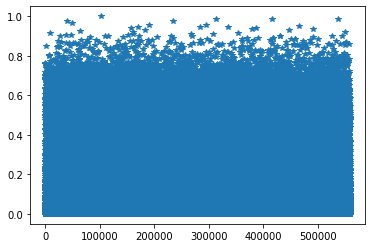

In [8]:
plt.plot(list(range(len(duration))), duration_normalized, '*')
plt.show()

In [9]:
min_gs = min(gs); max_gs = max(gs)

def normalize_gs(group_size):
    return (group_size - min_gs) / (max_gs - min_gs)

gs_normalized = list(map(normalize_gs, gs))

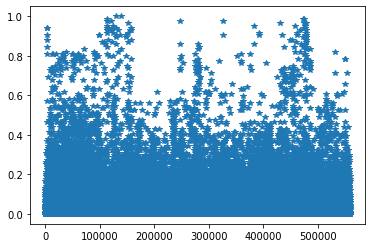

In [10]:
plt.plot(list(range(len(gs))), gs_normalized, '*')
plt.show()

In [11]:
from collections import defaultdict
action_risk = defaultdict(int)

for row_num, row in tqdm(actions_df.iterrows()):
    action_risk[row["container"]] += duration_normalized[row_num]
    action_risk[row["container"]] += gs_normalized[row_num]
    

558860it [01:02, 8948.93it/s] 


# Create timelines

In [12]:
timelines = {}

for group_id, group in tqdm(actions_df.groupby("person")):
    temp_line = []
    
    for row_id, row in group.iterrows():
        row_duration = normalize_duration(row["end_time"] - row["time"])
        row_group_size = normalize_gs(get_group_size(row["groupSize"]))
        temp_line.append({
            "container": row["container"],
            "duration": row_duration,
            "groupSize": row_group_size
        })
    
    if timelines.get(group_id, None):
        print(f"There is an existing {group_id}")
    
    timelines[group_id] = temp_line
    
    

100%|██████████| 108246/108246 [01:48<00:00, 998.73it/s] 


In [13]:
infections_file_path = Path("../simulation_data/v4/infectionEvents.txt")

In [14]:
infections = pd.read_csv(infections_file_path, sep="\t")

In [15]:
infection_risks = []

for row_id, row in tqdm(infections.iterrows()):
    infection_risks.append(action_risk[row["facility"]])

28248it [00:02, 9879.39it/s] 


In [16]:
np.argmin(infection_risks), infections.iloc[60]

(60,
 time                   539424
 infector              5744755
 infected              5744756
 infectionType       home_home
 date               2020-01-29
 groupSize                   2
 facility         home_2594069
 Name: 60, dtype: object)

In [17]:
from collections import Counter

In [18]:
cnt = Counter(infection_risks)

In [19]:
duration_normalized[60], gs_normalized[60]

(0.03225294686910031, 0.0)

In [20]:
infection_all = defaultdict(lambda : defaultdict(int))
infection_locations = defaultdict(int)

for row_id, row in tqdm(infections.iterrows()):
    infection_all[row["infected"]][row["facility"]] = 1
    infection_locations[row["facility"]] = 1

28248it [00:03, 8018.34it/s]


In [21]:
assert len(duration_normalized) == len(gs_normalized)

X = list(zip(duration_normalized, gs_normalized))
Y = []

for row_id, row in tqdm(actions_df.iterrows()):
    if infection_all[row["person"]][row["container"]] == 1:
        Y.append(1)
    else:
        Y.append(0)
X = np.array(X)
Y = np.array(Y)

558860it [00:57, 9757.14it/s] 


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [23]:
from sklearn.gaussian_process import GaussianProcessRegressor

gpr = GaussianProcessRegressor()

In [ ]:
gpr.fit(X_train, Y_train)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
Y_predict = gpr.predict(X_test)

In [ ]:
f1_score(Y_test, Y_pred)